In [2]:
#A little tutorial to build blocks and train neural networks using PyTorch by Max Vurro 2019

#Standard module from torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# for printing image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(torch.__version__)

1.2.0+cu92


In [7]:
## I am using the MNIST dataset (images 28x28 containing hand-written numbers) http://yann.lecun.com/exdb/mnist/ 
## Now I group image in batch of 32 image so I parameter the batch size
BATCH_SIZE = 32

## We will import and transform the data into tensors using the transforms module 
## In the context of machine learning, tensors are just efficient data structures used to store data
## the command transform holds code for whatever transformations you will apply to your data

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## Using DataLoader to build convenient data loaders 
## which makes it easy to efficiently feed data in batches (as subsets of your data) to neural network models. 

## download and load training dataset
## trainloader is what holds the data loader object which takes care of shuffling the data and constructing the batches
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [8]:
print(trainset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [10]:
print(testset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [14]:
## data is splitted into 85% (60000) trainset datapoints and  15% (10000) testset trainpoint

In [15]:
#randomly generated image 
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))

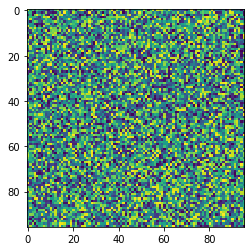

In [16]:
#rendering image
plt.imshow(image)

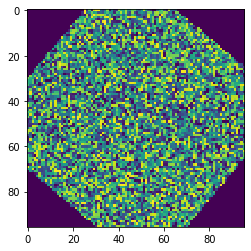

In [19]:
#rotate the image by 45 degrees
## dummy transformation
dummy_transform = transforms.Compose([transforms.RandomRotation(45)])

dummy_result = dummy_transform(image)

plt.imshow(dummy_result)

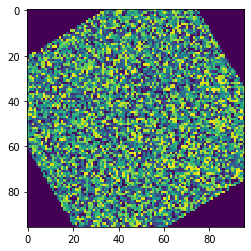

In [20]:
## I can put any transformations within transforms.Compose(...)
## I try to  rotate + vertical flip

## dummy transform 
dummy2_transform = transforms.Compose([transforms.RandomRotation(45), transforms.RandomVerticalFlip()])

dummy2_result = dummy2_transform(image)

plt.imshow(dummy2_result)

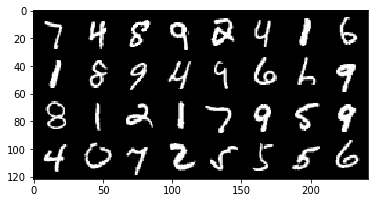

In [21]:
## EDA Data Exploration
## I will use the matplotlib library to print out some of the images from MNIST dataset
## With numpy code, I can convert images into a proper format to print them out
## Below I print out an entire batch of 32 images

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [22]:
# dimensions of our batches
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [23]:
## the model od 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.d2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        x = self.dropout(x)
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [24]:
## Test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [25]:
## Training the Model Part 1 (Settings)
# Learning date is the rate at which the model will try to optimize its weights
learning_rate = 0.001
# epochs is the number of training steps
num_epochs = 5

# device determines what hardware we will use to train the model. 
## If a gpu is present, then that will be used, otherwise, it defaults to the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
# criterion is just the metric that's used to compute the loss of the model while it
# forward and backward trains to optimize its weights
criterion = nn.CrossEntropyLoss()
# optimizer is the optimization technique used to modify the weights in the backward propagation step.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [26]:
## utility function to compute accuracy
# it compares the outputs of the model (predictions) with the actual target values (i.e., the labels of the dataset)
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [27]:
## Training the Model Part 2 (Operational)

#This spetp to monitor the running accuracy and loss of the model while it trains over the different batches
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## commence training
    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.5967 | Train Accuracy: 88.14
Epoch: 1 | Loss: 1.5286 | Train Accuracy: 93.42
Epoch: 2 | Loss: 1.5138 | Train Accuracy: 94.75
Epoch: 3 | Loss: 1.5052 | Train Accuracy: 95.53
Epoch: 4 | Loss: 1.4991 | Train Accuracy: 96.10


In [29]:
# After all the training steps are over, we can clearly see that the loss keeps decreasing while the training accuracy of the model keeps rising,  which is a good sign that the model is effectively learning to classify images

In [30]:
# Test the Accuracy
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.72
